In [1]:
library(mvtnorm)
library(rBeta2009)

Warning message:
"package 'mvtnorm' was built under R version 3.6.3"
Attaching package: 'rBeta2009'

The following object is masked from 'package:stats':

    rbeta



In [2]:
set.seed(50120057)

#### 1. $\mathbf{y} \sim \sum_{k=1}^{K}\pi_{k}\mathcal{N}(\mu_{k},1)$ 을 만족하는 데이터 생성
#### 2. $\pi = (\pi_{1},...,\pi_{k})$ 는 각각 non-negative하면서 합이 1이 되는 값들로 설정
#### 3. 여기에서는 K=3 으로 설정하겠다

In [3]:
mix_data = function(n,pi,mu,sd){
    z = sample(1:length(pi),prob=pi,size=n,replace=T)
    x = rnorm(n,mu[z],sd[z])
    return(x)
}
y = mix_data(n = 1000, pi = c(0.2,0.3,0.5), mu= c(-4,0,4), sd=c(1,1,1))

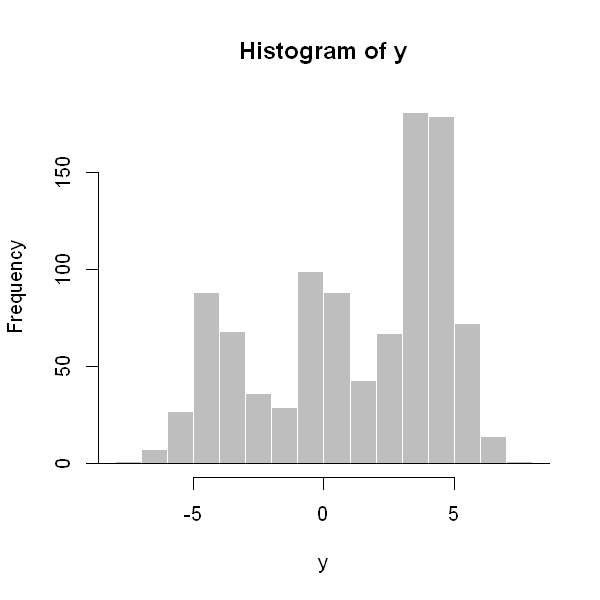

In [4]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(y, col= "grey", border = "white", breaks = 20)
lines(density(y))

#### 1. 데이터를 3개의 Class로 분류를 시도할 것이기 때문에 K=3 으로 설정
#### 2. J값은 앞서 예제를 위해 생성한 데이터의 개수, iteration 횟수는 임의 지정
#### 3. iteration에서 각 Sample 데이터를 저장할 수 있는 Matrix 생성

In [125]:
K = 3
J = 1000
iter = 10000

In [126]:
z_mat   = matrix(0, ncol = J, nrow = iter)
pi_mat  = matrix(0, ncol = K, nrow = iter)
mu_mat  = matrix(0, ncol = K, nrow = iter)

####  1. 우리의 관심 parameter $\Theta = (\mu,\pi) $ 이고 우리는 $p(\mu,\pi\vert y)$ 분포에 관심이 있다.
#### 2. Joint Posterior Distribution으로 바로 Sampling 하는 것은 어려워 각각의 Conditional Posterior Distribution을 구한다.
#### 3. 다만 Sampling을 용이하게 만들기 위해 latent variable $\mathbf{z}$를 사용하기 때문에 우리의 Target Joint Posterior Distribution은 $p(\pi,\mu,z\vert y)$ 이다.
- Sample z from $p(z\vert\mu,\pi,y)$
- Sample $\pi$ from $p(\pi\vert\mu,z,y)$
- Sample $\mu$ from $p(\mu\vert\pi,z,y)$

#### 4. Prior Distribution은 $\pi = (\pi_{1},...,\pi_{k}) \sim \text{Dirichlet}(\frac{1}{K},...,\frac{1}{K}), \quad  \mu_{k} \sim \mathcal{N}(0,10^{2})$

In [141]:
pi_mat[1,] =c(1/3,1/3,1/3)
z_mat[1,] = sample(1:K,prob=pi_mat[1,],size=J,replace=T)
mu_mat[1,] = rnorm(3,0,1)
prop = c()
    
  for(t in 2:iter){
    ### gibbs sampler for z ###
    for(j in 1:J){
      for(k in 1:K){
        prop[k] = exp(-0.5*(y[j]-mu_mat[t-1,k])^2)*pi_mat[t-1,k]
      }
      z_mat[t,j] = which.max(rmultinom(1,1,prop/(sum(prop))))
    }
    
    ### gibbs sampler for pi ###
    
    pi_mat[t,] = rdirichlet(1,c(sum(z_mat[t,]==1)+1/K, sum(z_mat[t,]==2)+1/K, sum(z_mat[t,]==3)+1/K))
    
    ### gibbs sampler for mu ###
    
    for(k in 1:K){
      sig = (sum(z_mat[t,]==k) + 1/(10^2))^(-1)
      mu = (sum(y[z_mat[t,]==k]))*sig
      mu_mat[t,k] = rnorm(1,mu,sqrt(sig))
    }
  }

#### 1. 각각의 parameter에 대한 Trace Plot 
#### 2. burn-in period 를 iteration 500으로 간주하고 그 이후의 Sampling 데이터만을 가지고 density plot 그리기
#### 3. 각각의 $\mu$와 $\pi$는 데이터를 생성할 때 사용했던 $\mu$값과 $\pi$값에 합리적으로 매칭 됨

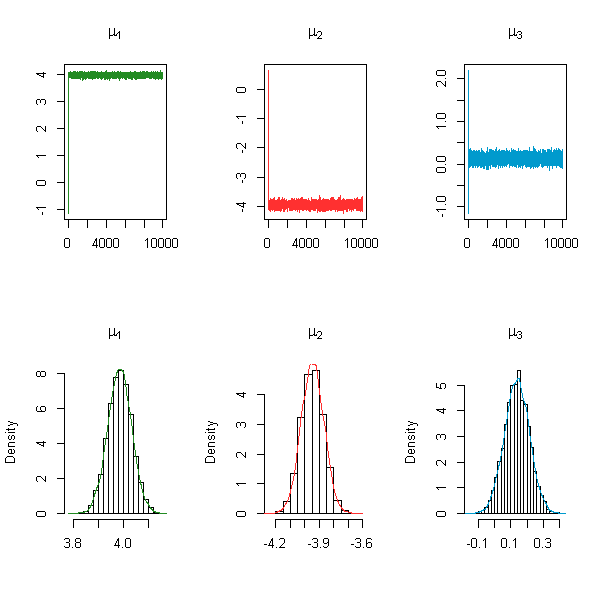

In [142]:
par(mfrow=c(2,3))

ts.plot(mu_mat[,1],type="l",xlab="",ylab="",main=expression(mu[1]),col='#228B22')
ts.plot(mu_mat[,2],type="l",xlab="",ylab="",main=expression(mu[2]),col='#FF3030')
ts.plot(mu_mat[,3],type='l',xlab="",ylab="",main=expression(mu[3]),col='#009ACD')

hist(mu_mat[-c(1:500),1],breaks=20,freq=FALSE,xlab="",main=expression(mu[1]))
lines(density(mu_mat[-c(1:500),1]),col='#228B22')
hist(mu_mat[-c(1:500),2],breaks=20,freq=FALSE,xlab="",main=expression(mu[2]))
lines(density(mu_mat[-c(1:500),2]),col='#FF3030')
hist(mu_mat[-c(1:500),3],breaks=20,freq=FALSE,xlab="",main=expression(mu[3]))
lines(density(mu_mat[-c(1:500),3]),col='#009ACD')

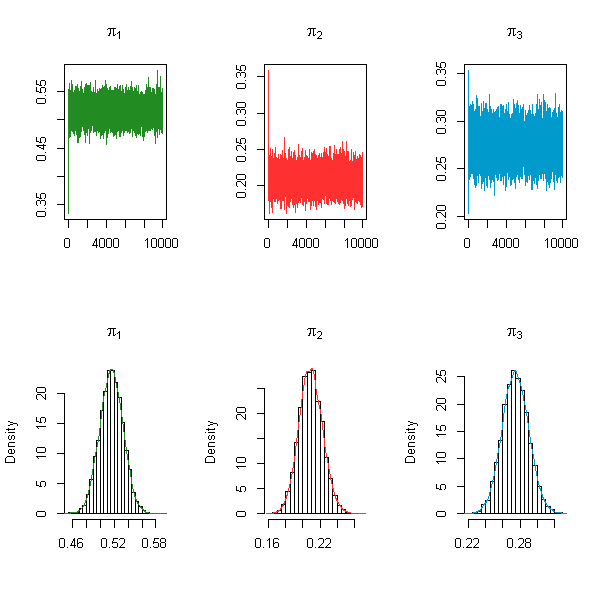

In [143]:
par(mfrow=c(2,3))

ts.plot(pi_mat[,1],type="l",xlab="",ylab="",main=expression(pi[1]),col='#228B22')
ts.plot(pi_mat[,2],type="l",xlab="",ylab="",main=expression(pi[2]),col='#FF3030')
ts.plot(pi_mat[,3],type='l',xlab="",ylab="",main=expression(pi[3]),col='#009ACD')

hist(pi_mat[-c(1:500),1],breaks=20,freq=FALSE,xlab="",main=expression(pi[1]))
lines(density(pi_mat[-c(1:500),1]),col='#228B22')
hist(pi_mat[-c(1:500),2],breaks=20,freq=FALSE,xlab="",main=expression(pi[2]))
lines(density(pi_mat[-c(1:500),2]),col='#FF3030')
hist(pi_mat[-c(1:500),3],breaks=20,freq=FALSE,xlab="",main=expression(pi[3]))
lines(density(pi_mat[-c(1:500),3]),col='#009ACD')